In [3]:
import re
import numpy as np
import pandas as pd
from sklearn import svm
from textblob import Word
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import grid_search
from sklearn.svm import LinearSVC
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer



C:\Users\sahit\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\sahit\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [186]:
#read the traindf dataset and see the head of teh data
traindf = pd.read_json("train_1.json")
traindf.head()


,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


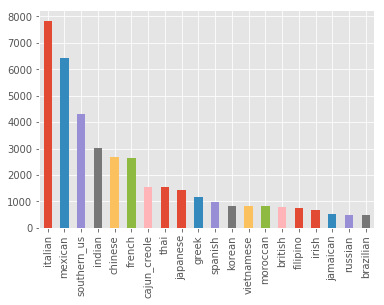

In [260]:
#We can see the structure of the data: a cuisine, an id for the recipe, and the ingredients.
#checking the number of cuisine present in the dataset.
#there are a lot of Italian, Mexican and Southern US recipes, a little less of the other recipes.
%matplotlib inline
traindf['cuisine'].value_counts().plot(kind='bar')

In [261]:
#we can count the most frequent ingredients for each cuisine. 
#To do that, we can use the Python counter objects (found in the collections module from the standard library).
counters = {}
for cuisine in traindf['cuisine'].unique():
    counters[cuisine] = Counter()
    indices = (traindf['cuisine'] == cuisine)
    for ingredients in traindf[indices]['ingredients']:
        counters[cuisine].update(ingredients) 

counters['indian'].most_common(10)

[('salt', 1934),
 ('onions', 1195),
 ('garam masala', 862),
 ('water', 820),
 ('ground turmeric', 728),
 ('garlic', 726),
 ('cumin seed', 697),
 ('ground cumin', 683),
 ('vegetable oil', 593),
 ('oil', 546)]

In [512]:
#changing it to a dataframe to see top 5 ingrediants of all the countries 
top5 = pd.DataFrame([[items[0] for items in counters[cuisine].most_common(5)] for cuisine in counters],
            index=[cuisine for cuisine in counters],
            columns=['top{}'.format(i) for i in range(1, 6)])
print(top5)

                    top1               top2               top3  \
greek               salt          olive oil      dried oregano   
southern_us         salt             butter  all-purpose flour   
filipino            salt             garlic              water   
indian              salt             onions       garam masala   
jamaican            salt             onions              water   
spanish             salt          olive oil      garlic cloves   
italian             salt          olive oil      garlic cloves   
mexican             salt             onions       ground cumin   
chinese        soy sauce         sesame oil               salt   
british             salt  all-purpose flour             butter   
thai          fish sauce             garlic               salt   
vietnamese    fish sauce              sugar               salt   
cajun_creole        salt             onions             garlic   
brazilian           salt             onions          olive oil   
french    

In [511]:
#saving the top 5 ingredients to a csv file for use in the network visualization.
top5_value = pd.DataFrame([[items[0] for items in counters[cuisine].most_common(5)] for cuisine in counters],
            index=[cuisine for cuisine in counters])
            #columns=['top{}'.format(i) for i in range(1, 6)])
#print(top5)
#top5.to_csv("top5 ingrediants country wise.csv")
top5_value=top5_value.stack()
top5_value.to_csv("top5 ingrediants country wise.csv")

            

In [498]:
#ngram
TextBlob(traindf['ingredients_clean_string'][0]).ngrams(3)

[WordList(['romaine', 'lettuce', 'black']),
 WordList(['lettuce', 'black', 'olives']),
 WordList(['black', 'olives', 'grape']),
 WordList(['olives', 'grape', 'tomatoes']),
 WordList(['grape', 'tomatoes', 'garlic']),
 WordList(['tomatoes', 'garlic', 'pepper']),
 WordList(['garlic', 'pepper', 'purple']),
 WordList(['pepper', 'purple', 'onion']),
 WordList(['purple', 'onion', 'seasoning']),
 WordList(['onion', 'seasoning', 'garbanzo']),
 WordList(['seasoning', 'garbanzo', 'beans']),
 WordList(['garbanzo', 'beans', 'feta']),
 WordList(['beans', 'feta', 'cheese']),
 WordList(['feta', 'cheese', 'crumbles'])]

In [496]:
# Auxiliar function for cleaning
stemmer = WordNetLemmatizer()
traindf['ingredients_clean_string'] = [','.join(z).strip() for z in traindf['ingredients']]  

# Remove Punctuation
traindf['ingredients_string'] = [' '.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line)) 
                                           for line in lists]).strip() for lists in traindf['ingredients']]  
#lower case
traindf['ingredients_clean_string']  = [ str.lower(i) for i in traindf['ingredients_clean_string'] ]
## Remove digits
traindf['ingredients_clean_string']  = [ i for i in traindf['ingredients_clean_string'] if not i.isdigit() ]
# Stem ingredients
traindf['ingredients_clean_string']  = [ stemmer.lemmatize(i) for i in traindf['ingredients_clean_string'] ]
#Lemmatization 
traindf['ingredients_clean_string'] = traindf['ingredients_clean_string'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
#remove white space
traindf['ingredients_clean_string'] = [" ".join(i.split())for i in traindf['ingredients_clean_string']]

def replacing(i):
        i = i.replace('&', '').replace('(', '').replace(')','')
        i = i.replace('\'', '').replace('\\', '')
        i = i.replace('.', '').replace('%', '').replace('/','')
        i = i.replace('"', '')
        
        return i
# Replacing characters
traindf['ingredients_clean_string']  = [ replacing(i) for i in traindf['ingredients_clean_string'] ]

In [505]:
traindf.head()

,cuisine,id,ingredients,ingredients_clean_string,ingredients_string
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...","romaine lettuce,black olives,grape tomatoes,ga...",romaine lettuce black olives grape tomatoes ga...
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...","plain flour,ground pepper,salt,tomatoes,ground...",plain flour ground pepper salt tomato ground b...
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...","eggs,pepper,salt,mayonaise,cooking oil,green c...",egg pepper salt mayonaise cooking oil green ch...
3,indian,22213,"[water, vegetable oil, wheat, salt]","water,vegetable oil,wheat,salt",water vegetable oil wheat salt
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...","black pepper,shallots,cornflour,cayenne pepper...",black pepper shallot cornflour cayenne pepper ...


In [499]:
#Term frequency
#TF = (Number of times term T appears in the particular row) / (number of terms in that row)
tf1 = (traindf['ingredients_clean_string'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['ing','tf']
tf1

,ing,tf
0,"pepper,salt,tomatoes,ground",1
1,"pepper,thyme,eggs,green",1
2,corn,1
3,"tomatoes,yellow",1
4,"meal,milk,vegetable",1
5,oil,1
6,plain,1
7,black,1
8,"flour,ground",1


In [501]:
#idf
#IDF = log(N/n), where, N is the total number of rows and n is the number of rows in which the word was present.
for i,word in enumerate(tf1['ing']):
  tf1.loc[i, 'idf'] = np.log(traindf.shape[0]/(len(traindf[traindf['ingredients_clean_string'].str.contains(word)])))

tf1

,ing,tf,idf
0,"pepper,salt,tomatoes,ground",1,10.590969
1,"pepper,thyme,eggs,green",1,10.590969
2,corn,1,1.831143
3,"tomatoes,yellow",1,6.356862
4,"meal,milk,vegetable",1,10.590969
5,oil,1,0.620337
6,plain,1,3.814462
7,black,1,1.354181
8,"flour,ground",1,5.038009


In [504]:
tf1['tfidf'] = tf1['tf'] * tf1['idf']
tf1

,ing,tf,idf,tfidf
0,"pepper,salt,tomatoes,ground",1,10.590969,10.590969
1,"pepper,thyme,eggs,green",1,10.590969,10.590969
2,corn,1,1.831143,1.831143
3,"tomatoes,yellow",1,6.356862,6.356862
4,"meal,milk,vegetable",1,10.590969,10.590969
5,oil,1,0.620337,0.620337
6,plain,1,3.814462,3.814462
7,black,1,1.354181,1.354181
8,"flour,ground",1,5.038009,5.038009


In [ ]:
testdf = pd.read_json("test_1.json") 
testdf['ingredients_clean_string'] = [' , '.join(z).strip() for z in testdf['ingredients']]
testdf['ingredients_string'] = [' '.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line)) for line in lists]).strip() for lists in testdf['ingredients']]       


In [ ]:

#Remove Stopwords
corpustr = traindf['ingredients_string']
vectorizertr = TfidfVectorizer(stop_words='english',
                             ngram_range = ( 1 , 1 ),analyzer="word", 
                             max_df = .35 , binary=False , token_pattern=r'\w+' , sublinear_tf=False)
tfidftr=vectorizertr.fit_transform(corpustr).todense()
corpusts = testdf['ingredients_string']
vectorizerts = TfidfVectorizer(stop_words='english')
tfidfts=vectorizertr.transform(corpusts)

predictors_tr = tfidftr
targets_tr = traindf['cuisine']
predictors_ts = tfidfts

parameters = {'C':[1, 10]}
clf = LinearSVC(C = 0.5)
classifier = grid_search.GridSearchCV(clf, parameters)

classifier=classifier.fit(predictors_tr,targets_tr)

predictions=classifier.predict(predictors_ts)

testdf['cuisine'] = predictions
testdf = testdf.sort_values('id' , ascending=True)

testdf[['cuisine','ingredients_clean_string' ]].to_csv("submission_1.csv")
#nx.write_gml(testdf[['id' , 'ingredients_clean_string' , 'cuisine' ]],"submission_1.csv")

print("Result in submission_1 CSV")

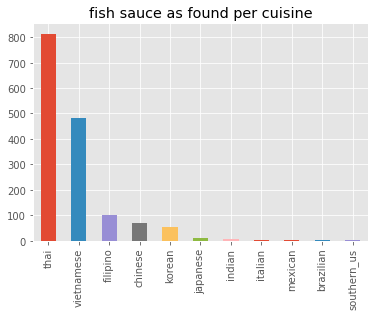

In [316]:
indices = traindf['ingredients_clean_string'].str.contains('fish sauce')
traindf[indices]['cuisine'].value_counts().plot(kind='bar',
                                                 title='fish sauce as found per cuisine')

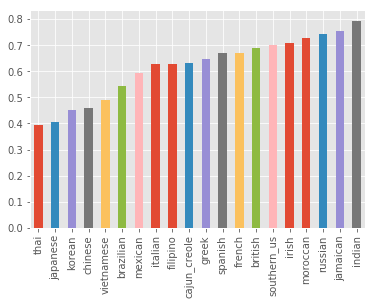

In [312]:
relative_freq = (traindf[indices]['cuisine'].value_counts() / traindf['cuisine'].value_counts())
relative_freq.sort_values(inplace=True)
relative_freq.plot(kind='bar')

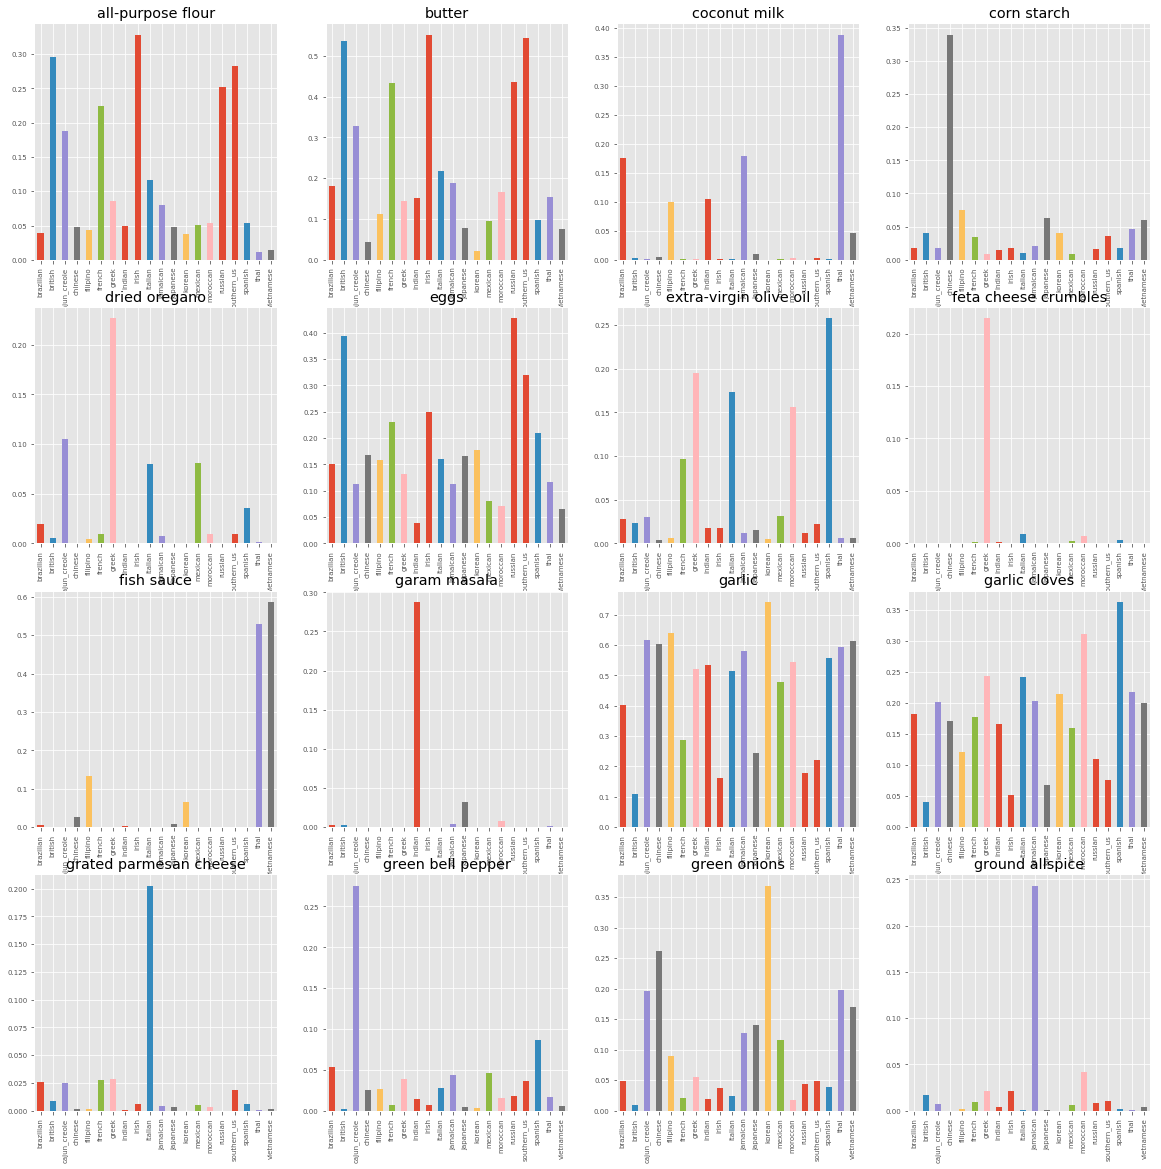

In [292]:
unique = np.unique(top5.values.ravel())
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
for ingredient, ax_index in zip(unique, range(16)):
    indices = traindf['ingredients_clean_string'].str.contains(ingredient)
    relative_freq = (traindf[indices]['cuisine'].value_counts() / traindf['cuisine'].value_counts())
    relative_freq.plot(kind='bar', ax=axes.ravel()[ax_index], fontsize=7, title=ingredient)


In [475]:
unique = np.unique(top5.values.ravel())
for ingredient, ax_index in zip(unique, range(16)):
    indices = traindf['ingredients_clean_string'].str.contains(ingredient)
    indices

In [323]:
#We will use scikit-learn to perform our classification. First, we will need to encode our features to a matrix that 
#the machine learning algorithms in scikit learn can use. This is done using a count vectorizer:
cv = CountVectorizer()
X = cv.fit_transform(traindf['ingredients_clean_string'].values)
print(X.shape)
##Each feature gets assigned a column number, which is assigned a 1 or a 0 depending on the presence or not of the ingredient.
print(list(cv.vocabulary_.keys())[:20])
#Now that we have our feature matrix, we still need to encode the labels that represent the cuisine of each recipe.
#This is done with a label encoder:
enc = LabelEncoder()
y = enc.fit_transform(traindf.cuisine)
#The variable y is now a vector with number instead of strings for each cuisine:
print(y[:100])
#We can check the result by inspecting the encoders classes:
print(enc.classes_)

(39774, 3054)
['romaine', 'lettuce', 'black', 'olives', 'grape', 'tomatoes', 'garlic', 'pepper', 'purple', 'onion', 'seasoning', 'garbanzo', 'beans', 'feta', 'cheese', 'crumbles', 'plain', 'flour', 'ground', 'salt']
[ 6 16  4  7  7 10 17  9 13  9  9  3  9 13  9  7  1  9 18 19 18 13 16  3
  9  3  2  9  3 13  9  2 13 18  9  2  9  4 16 16  9  0 13  7 13  3  5 16
 16 16 11 16  9 16  9 10 11  7  9  8 18 18  7 10  9 18 12  5  5 16 17  7
 14  9  9 14 14 19 11 13  2 16  5  7  7  9  9  7 12 17  9 16 16  6 13 13
 16  7  9  9]
['brazilian' 'british' 'cajun_creole' 'chinese' 'filipino' 'french'
 'greek' 'indian' 'irish' 'italian' 'jamaican' 'japanese' 'korean'
 'mexican' 'moroccan' 'russian' 'southern_us' 'spanish' 'thai'
 'vietnamese']


In [324]:
#split the dataset so that we can also test our classifier on data that he hasn't seen before:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#train a logistic regression:
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

print(logistic.score(X_test, y_test))

0.7849151477058454


In [ ]:
#plt.scatter(top5.index,top5["top1"])
#plt.show()
#clf1 = svm.SVC(kernel='linear', C = 1.0)
#clf1.fit(predictors_tr,targets_tr)

In [182]:
testdf.head()

,id,ingredients,ingredients_clean_string,ingredients_string,cuisine
4987,5,"[mushrooms, chopped onion, tomato sauce, chees...","mushrooms , chopped onion , tomato sauce , che...",mushroom chopped onion tomato sauce cheese dri...,mexican
9232,7,"[minced garlic, brown rice, sour cream, chicke...","minced garlic , brown rice , sour cream , chic...",minced garlic brown rice sour cream chicken re...,indian
9638,11,"[lime juice, sesame oil, garlic cloves, fish s...","lime juice , sesame oil , garlic cloves , fish...",lime juice sesame oil garlic cloves fish sauce...,vietnamese
4927,12,"[sugar, vanilla extract, corn starch, coffee g...","sugar , vanilla extract , corn starch , coffee...",sugar vanilla extract corn starch coffee granu...,italian
3280,13,"[frozen pie crust, bourbon whiskey, powdered s...","frozen pie crust , bourbon whiskey , powdered ...",frozen pie crust bourbon whiskey powdered suga...,southern_us


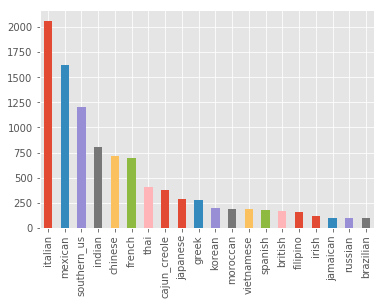

In [200]:
fig=testdf['cuisine'].value_counts().plot(kind='bar')

In [177]:
recipe = [ str.lower(i) for recipe in testdf['ingredients'] for i in recipe ]
## Remove digits
recipe = [ i for recipe in testdf['ingredients'] for i in recipe if not i.isdigit() ]
# Stem ingredients
recipe = [ stemmer.lemmatize(i) for recipe in testdf['ingredients'] for i in recipe ]
#remove white space
recipe= [" ".join(i.split())for recipe in testdf['ingredients'] for i in recipe ]

def replacing(i):
        i = i.replace('&', '').replace('(', '').replace(')','')
        i = i.replace('\'', '').replace('\\', '').replace(',','')
        i = i.replace('.', '').replace('%', '').replace('/','')
        i = i.replace('"', '')
        
        return i
# Replacing characters
recipe = [ replacing(i) for recipe in testdf['ingredients'] for i in recipe ]


In [178]:
# The number of times each ingredient is used is stored in the 'sumbags' dictionary
bags_of_words = [ Counter(recipe) for recipe in testdf.ingredients ]
sumbags = sum(bags_of_words,Counter())

In [452]:
bags_of_words

[Counter({'cheese': 1,
          'chili powder': 1,
          'chopped onion': 1,
          'dried oregano': 1,
          'garlic cloves': 1,
          'lean ground turkey': 1,
          'mushrooms': 1,
          'salt': 1,
          'tomato sauce': 1,
          'tortillas': 1}),
 Counter({'(14.5 oz.) diced tomatoes': 1,
          'brown rice': 1,
          'celery': 1,
          'chicken': 1,
          'chickpeas': 1,
          'fresh ginger': 1,
          'garam masala': 1,
          'ground cardamom': 1,
          'ground cayenne pepper': 1,
          'ground cumin': 1,
          'ground turmeric': 1,
          'minced garlic': 1,
          'olive oil': 1,
          'onions': 1,
          'red lentils': 1,
          'sour cream': 1}),
 Counter({'button mushrooms': 1,
          'cilantro': 1,
          'extra-virgin olive oil': 1,
          'fish sauce': 1,
          'garlic cloves': 1,
          'green onions': 1,
          'jalapeno chilies': 1,
          'large shrimp': 1,
       

{'salt': 4485, 'onions': 2036, 'olive oil': 1917, 'water': 1836, 'garlic': 1791}


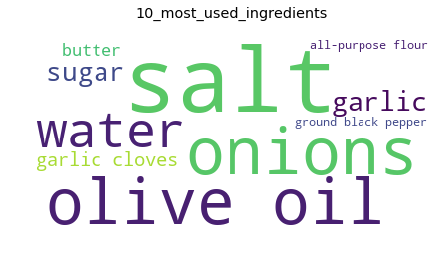

In [337]:
# Finally, plot the 10 most used ingredients
fig1 = pd.DataFrame(sumbags, index=[0]).transpose()[0].sort_values(ascending=False, inplace=False)[:10]
#fig.savefig('10_most_used_ingredients.jpg')
print(dict(Counter(sumbags).most_common(5)))
wordcloud = WordCloud(background_color="white",max_font_size=90, random_state=42).generate_from_frequencies(fig1)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.title('10_most_used_ingredients\n')
plt.tight_layout(pad=0)
plt.show()


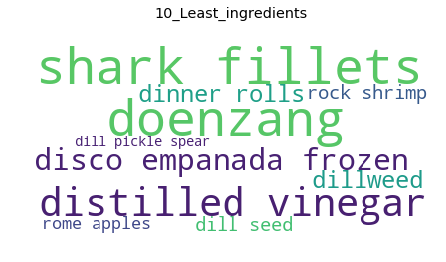

In [192]:
# Finally, plot the 10 most used ingredients
fig2 = pd.DataFrame(sumbags, index=[0]).transpose()[0].sort_values(ascending=True, inplace=False)[:10]
#fig.savefig('10_most_used_ingredients.jpg')
wordcloud = WordCloud(background_color="white",max_font_size=90, random_state=42).generate_from_frequencies(fig2)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.title('10_Least_ingredients\n')
plt.tight_layout(pad=0)
plt.show()

In [4]:
import csv

In [11]:
a = pd.read_csv("top5 ingrediants country wise.csv")

In [24]:
a.columns=['Cuisine','Count','ingredients']
a

,Cuisine,Count,ingredients
0,greek,1,olive oil
1,greek,2,dried oregano
2,greek,3,garlic cloves
3,greek,4,feta cheese crumbles
4,southern_us,0,salt
5,southern_us,1,butter
6,southern_us,2,all-purpose flour
7,southern_us,3,sugar
8,southern_us,4,large eggs
9,filipino,0,salt


In [7]:
#code use to get latitiude and longitude to get the visualizations in tableau
from geopy.geocoders import Nominatim
geolocator = Nominatim()
for i in a['cuisine']:
    
    location = geolocator.geocode(i)
    print('{}'.format(i),location.latitude, location.longitude)

#location = geolocator.reverse("51.7264876, -3.0828006")
#print(location)


mexican -25.7182 28.20276
indian 47.5173378 -53.3013817
vietnamese 10.7644192 106.6952576
italian 37.465627 -119.851168


AttributeError: 'NoneType' object has no attribute 'latitude'

(13.2904027, 108.4265113)


British, Torfaen, Wales, NP4 7US, UK


In [397]:
a.to_csv